In [ ]:
import os
import cv2
import numpy as np
import string
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional

from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu, sigmoid, softmax

from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm import tqdm
from collections import Counter

from PIL import Image

In [ ]:
!unzip -qq /content/drive/MyDrive/mjsynth_sample.zip

In [ ]:

final_paths = []
final_texts = []

data_folder = '/content/mjsynth_sample'
for path in os.listdir(data_folder):


    final_paths.append(data_folder + "/" + path)
    final_texts.append(path.split("_")[1])

In [ ]:
final_paths[:10], final_texts[:10]

(['/content/mjsynth_sample/447_Frontward_31039.jpg',
  '/content/mjsynth_sample/8_Script_68689.jpg',
  '/content/mjsynth_sample/246_succumbing_75835.jpg',
  '/content/mjsynth_sample/203_MISTRAL_49113.jpg',
  '/content/mjsynth_sample/379_BU_9915.jpg',
  '/content/mjsynth_sample/228_JUNKETS_41989.jpg',
  '/content/mjsynth_sample/288_consenting_16230.jpg',
  '/content/mjsynth_sample/3_FIBRILS_28725.jpg',
  '/content/mjsynth_sample/6_denis_20593.jpg',
  '/content/mjsynth_sample/153_Interpretive_40333.jpg'],
 ['Frontward',
  'Script',
  'succumbing',
  'MISTRAL',
  'BU',
  'JUNKETS',
  'consenting',
  'FIBRILS',
  'denis',
  'Interpretive'])

In [ ]:
vocab = set("".join(map(str, final_texts)))
print(sorted(vocab))

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [ ]:

Counter("".join(map(str, final_texts)))

Counter({'0': 38,
         '1': 56,
         '2': 30,
         '3': 21,
         '4': 26,
         '5': 16,
         '6': 16,
         '7': 15,
         '8': 17,
         '9': 10,
         'A': 12188,
         'B': 3874,
         'C': 7202,
         'D': 6379,
         'E': 16729,
         'F': 2799,
         'G': 4768,
         'H': 3898,
         'I': 12696,
         'J': 518,
         'K': 1611,
         'L': 7997,
         'M': 4745,
         'N': 10222,
         'O': 8783,
         'P': 5178,
         'Q': 350,
         'R': 11125,
         'S': 14094,
         'T': 10070,
         'U': 4990,
         'V': 1787,
         'W': 1806,
         'X': 428,
         'Y': 2289,
         'Z': 696,
         'a': 21612,
         'b': 4718,
         'c': 10014,
         'd': 9727,
         'e': 31936,
         'f': 3274,
         'g': 8370,
         'h': 6096,
         'i': 24247,
         'j': 453,
         'k': 2761,
         'l': 14693,
         'm': 6928,
         'n': 20242,
         'o'

In [ ]:
char_list = sorted(vocab)

def encode_to_labels(txt):
    # encoding each output word into digits
    dig_lst = []
    
    for index, char in enumerate(txt):
        try:
            dig_lst.append(char_list.index(char))
        except:
            print(char)
        
    return dig_lst

In [ ]:

train_final_paths = final_paths[ : int(len(final_paths) * 0.90)]
train_final_texts = final_texts[ : int(len(final_texts) * 0.90)]

val_final_paths = final_paths[int(len(final_paths) * 0.90) : ]
val_final_texts = final_texts[int(len(final_texts) * 0.90) : ]

In [ ]:
len(train_final_paths), len(val_final_paths)

(47427, 5270)

In [ ]:
max_label_len = max([len(str(text)) for text in final_texts])
print(max_label_len)

23


In [ ]:
class My_Generator(Sequence):
    
    def __init__(self, image_filenames, labels, batch_size):
        self.image_filenames, self.labels = image_filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        
        batch_paths = self.image_filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_texts = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        images = []
        training_txt = []
        train_label_length = []
        train_input_length = []

        for im_path, text in zip(batch_paths, batch_texts):
            
            try:
                text = str(text).strip()
                img = cv2.cvtColor(cv2.imread(im_path), cv2.COLOR_BGR2GRAY)   

                ### actually returns h, w
                h, w = img.shape

                ### if height less than 32
                if h < 32:
                    add_zeros = np.ones((32-h, w)) * 255
                    img = np.concatenate((img, add_zeros))
                    h = 32

                ## if width less than 128
                if w < 128:
                    add_zeros = np.ones((h, 128-w)) * 255
                    img = np.concatenate((img, add_zeros), axis=1)
                    w = 128

                ### if width is greater than 128 or height greater than 32
                if w > 128 or h > 32:
                    img = cv2.resize(img, (128, 32))

                img = np.expand_dims(img , axis = 2)

                # Normalize each image
                img = img / 255.

                images.append(img)
                training_txt.append(encode_to_labels(text))
                train_label_length.append(len(text))
                train_input_length.append(31)
            except:
                
                pass

        return [np.array(images), 
               pad_sequences(training_txt, maxlen=max_label_len, padding='post', value=len(char_list)), 
               np.array(train_input_length), 
               np.array(train_label_length)], np.zeros(len(images))


In [ ]:
batch_size = 128
train_generator = My_Generator(train_final_paths, train_final_texts, batch_size)
val_generator = My_Generator(val_final_paths, val_final_texts, batch_size)

In [ ]:
# input with shape of height=32 and width=128 
inputs = Input(shape=(32, 128, 1))

conv_1 = Conv2D(16, (3,3), activation = 'relu', padding='same')(inputs)
pool_1 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_1)
 
conv_2 = Conv2D(32, (3,3), activation = 'relu', padding='same')(pool_1)
pool_2 = MaxPool2D(pool_size=(2, 2), strides=2)(conv_2)

conv_3 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_2)
conv_4 = Conv2D(64, (3,3), activation = 'relu', padding='same')(conv_3)
pool_4 = MaxPool2D(pool_size=(2, 1))(conv_4)
 
conv_5 = Conv2D(64, (3,3), activation = 'relu', padding='same')(pool_4)
# Batch normalization layer
batch_norm_5 = BatchNormalization()(conv_5)
 
conv_6 = Conv2D(64, (3,3), activation = 'relu', padding='same')(batch_norm_5)
batch_norm_6 = BatchNormalization()(conv_6)
pool_6 = MaxPool2D(pool_size=(2, 1))(batch_norm_6)
 
conv_7 = Conv2D(64, (2,2), activation = 'relu')(pool_6)
 
squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_7)
 
# bidirectional LSTM layers with units=128
blstm_1 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(squeezed)
blstm_2 = Bidirectional(CuDNNLSTM(128, return_sequences=True))(blstm_1)

outputs = Dense(len(char_list) + 1, activation = 'softmax')(blstm_2)

# model to be used at test time
reco_text_model = Model(inputs, outputs)

In [ ]:
reco_text_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 128, 1)]      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 128, 16)       160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 64, 16)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 32, 32)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 32, 64)         18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 32, 64)         36928 

In [ ]:
labels = Input(name='the_labels', shape=[max_label_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args 
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)
 
loss_out = Lambda(ctc_lambda_func, 
                  output_shape=(1,), 
                  name='ctc')([outputs, labels, input_length, label_length])

#model to be used at training time
model = Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [ ]:
file_path = "text_reco_model.hdf5"

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')


checkpoint = ModelCheckpoint(filepath=file_path, 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

callbacks_list = [checkpoint]

In [ ]:
epochs = 20

history = model.fit(train_generator, 
                    epochs = epochs,
                    steps_per_epoch = len(train_final_paths) // batch_size,
                    validation_data=val_generator,
                    validation_steps = len(val_final_paths) // batch_size,
                    verbose = 0,
                    callbacks = callbacks_list,
                    shuffle=True)


Epoch 00001: val_loss improved from inf to 29.44557, saving model to text_reco_model.hdf5

Epoch 00002: val_loss improved from 29.44557 to 17.09373, saving model to text_reco_model.hdf5

Epoch 00003: val_loss improved from 17.09373 to 9.44150, saving model to text_reco_model.hdf5

Epoch 00004: val_loss improved from 9.44150 to 7.19574, saving model to text_reco_model.hdf5

Epoch 00005: val_loss improved from 7.19574 to 6.46330, saving model to text_reco_model.hdf5

Epoch 00006: val_loss improved from 6.46330 to 5.66988, saving model to text_reco_model.hdf5

Epoch 00007: val_loss improved from 5.66988 to 5.54549, saving model to text_reco_model.hdf5

Epoch 00008: val_loss improved from 5.54549 to 5.37716, saving model to text_reco_model.hdf5

Epoch 00009: val_loss improved from 5.37716 to 5.17232, saving model to text_reco_model.hdf5

Epoch 00010: val_loss did not improve from 5.17232

Epoch 00011: val_loss improved from 5.17232 to 4.92884, saving model to text_reco_model.hdf5

Epoch 0

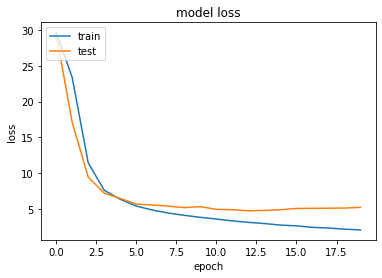

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def pre_process_image(path):
    
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)
    ### actually returns h, w
    h, w = img.shape

    ### if height less than 32
    if h < 32:
        add_zeros = np.ones((32-h, w)) * 255
        img = np.concatenate((img, add_zeros))
        h = 32

    ## if width less than 128
    if w < 128:
        add_zeros = np.ones((h, 128-w)) * 255
        img = np.concatenate((img, add_zeros), axis=1)
        w = 128

    ### if width is greater than 128 or height greater than 32
    if w > 128 or h > 32:
        img = cv2.resize(img, (128, 32))

    
    img = np.expand_dims(img , axis = 2)

    # Normalize each image
    img = img / 255.
    
    return img

In [ ]:
reco_text_model.load_weights('/content/text_reco_model.hdf5')

In [ ]:

def predict_output(img):
    # predict outputs on validation images
    prediction = reco_text_model.predict(np.array([img]))
    ## shape (batch_size, num_timesteps, vocab_size)

    # use CTC decoder
    out = K.get_value(K.ctc_decode(prediction, 
                                   input_length=np.ones(prediction.shape[0]) * prediction.shape[1],
                                   greedy=True)[0][0])

    ## get the final text    
    for x in out:

        print("predicted text = ", end = '')

        for p in x:

            if int(p) != -1:
                print(char_list[int(p)], end = '')
        
        print('\n')



predicted text = syringing





predicted text = steamfitter





predicted text = Crasswinds





predicted text = OUTLNING





predicted text = DISAMBIGUALE





predicted text = COCKTAL



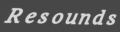



predicted text = Resounds





predicted text = ARCHENEMY





predicted text = OVERHAND





predicted text = Eerens



In [ ]:
from IPython.display import display
from random import randrange

for i in range(10):
    index = randrange(len(val_final_paths))
    im = Image.open(val_final_paths[index])
    display(im)

    print("\n")

    test_img = pre_process_image(val_final_paths[index])
    predict_output(test_img)